In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt

import glob
import xarray as xr
import datetime

In [ ]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

In [4]:
dtype = torch.complex64  # fft required data type

In [5]:
def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

# Pick the Dataset

In [6]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [7]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [8]:
f_sel = 50
dataFile = file_list[f_sel]

In [9]:
h_ds = xr.open_dataset(dataFile)

# Build Histogram For Labels

In [67]:
n_bins = 100  # number of bins in histogram
n_holograms = 300  # number of holograms to use in data set
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers
hologram_slice = slice(None,2*n_holograms)

In [68]:
histogram_lst = []
for holo_idx in h_ds['hologram_number'].values[hologram_slice]:
    hist_tpl = np.histogram(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],bins=z_bins)
    histogram_lst.append(hist_tpl[0])

Text(0.5, 0, 'z position [$\\mu m$]')

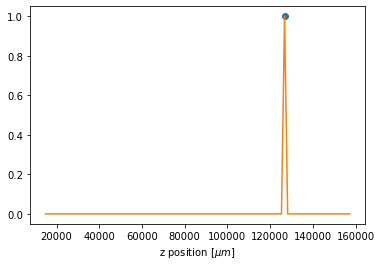

In [69]:
# confirm histogram and particle data are aligned
plt.figure()
plt.plot(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],np.ones(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)].shape),'o')
plt.plot(z_centers,histogram_lst[holo_idx])
plt.xlabel('z position [$\mu m$]')

In [70]:
histogram_arr = np.stack(histogram_lst,axis=0)
train_histogram_bin_arr = (histogram_arr[:n_holograms,:]>0).astype(float)
valid_histogram_bin_arr = (histogram_arr[n_holograms:,:]>0).astype(float)

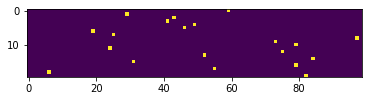

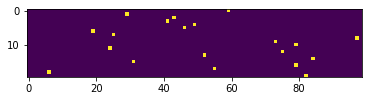

In [71]:
plt.figure()
plt.imshow(histogram_arr[0:20,:])
plt.figure()
plt.imshow(train_histogram_bin_arr[0:20,:])

# Build Reconstructed Plane Inputs

In [72]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0
n_planes = 7               # number of planes used in conv3d

In [73]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [74]:
fx = torch.fft.fftfreq(Nx,dx,device=device)[None,:,None]
fy = torch.fft.fftfreq(Ny,dy,device=device)[None,None,:]
z_rec = torch.tensor(z_centers*1e-6,device=device)[:,None,None]

Test Reconstruction Assumptions

(1, 600, 400)
(600,)
(400,)


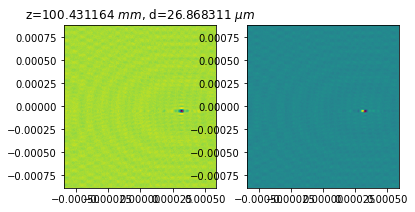

In [75]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]
z_plane = torch.tensor(zp*1e-6,device=device)[:,None,None]
E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
Eres = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

print(Eres.shape)
print(x_arr.shape)
print(y_arr.shape)

for idx,z in enumerate(zp):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    ax[0].pcolormesh(y_arr,x_arr,np.abs(Eres[idx,:,:]))
    ax[0].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].pcolormesh(y_arr,x_arr,np.angle(Eres[idx,:,:]))
    ax[1].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)

In [76]:
Eset1 = []
Eset2 = []
histset = []
start_time = datetime.datetime.now()
for holo_idx in range(2*n_holograms):
    part_idx = np.where(histogram_arr[holo_idx,:] > 0)[0]
    part_idx = part_idx[(part_idx > (n_planes//2)) & (part_idx < z_centers.size-(n_planes//2))]
    empt_idx = np.where(histogram_arr[holo_idx,:] == 0)[0]
    empt_idx = empt_idx[(empt_idx > (n_planes//2)) & (empt_idx < z_centers.size-(n_planes//2))]
    if len(empt_idx) > 0 and len(part_idx) > 0:
        set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
        set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
        plane_set = []
        for plane_idx in np.concatenate([set_part,set_empt]):
            plane_set.append(np.arange(-(n_planes//2),n_planes//2+1)+plane_idx)

        z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate(plane_set)],device=device)[:,None,None]
        E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values/image_norm,device=device,dtype=dtype)[None,:,:] 
        Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu().reshape((2*num_per_holo,1,n_planes,Nx,Ny)).permute(0,1,3,4,2)
    #     Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))
#         Eset1.append(Eres.abs())
#         Eset2.append(Eres.angle())
        Eset1.append(Eres.real)
        Eset2.append(Eres.imag)
        histset.append(histogram_arr[holo_idx,np.concatenate([set_part,set_empt])])

#     # Include All Reconstructions
#     E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
#     Eres = torch_holo_set(E_input,fx,fy,z_rec,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
#     # Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))


end_time = datetime.datetime.now()

In [77]:
exec_time = end_time-start_time
print(f'executed {2*num_per_holo*len(Eset1)} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/(2*num_per_holo*len(Eset1))} seconds per plane')

# exec_time = end_time-start_time
# print(f'executed {z_centers.size*len(Eset)} planes in {exec_time.total_seconds()} seconds')
# print(f' for {exec_time.total_seconds()/(z_centers.size*len(Eset))} seconds per plane')

executed 3722 planes in 58.227941 seconds
 for 0.015644261418592154 seconds per plane


In [78]:
idx_arr = np.arange(len(Eset1)).astype(int)
train_idx = np.random.choice(idx_arr, idx_arr[-1]//2 ,replace=False)
valid_idx = np.delete(idx_arr,train_idx)

In [79]:
train_inputs1 = torch.cat(Eset1,dim=0)[train_idx,...]
valid_inputs1 = torch.cat(Eset1,dim=0)[valid_idx,...]
train_inputs2 = torch.cat(Eset2,dim=0)[train_idx,...]
valid_inputs2 = torch.cat(Eset2,dim=0)[valid_idx,...]

KeyboardInterrupt: 

In [ ]:
hist_labels = np.concatenate(histset)

In [ ]:
idx = np.where(hist_labels[train_idx]>0)[0][25]
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(train_inputs1[idx,0,:,:,3])
ax[1].imshow(train_inputs2[idx,0,:,:,3])


idx = np.where(hist_labels[valid_idx]>0)[0][4]
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(valid_inputs1[idx,0,:,:,3])
ax[1].imshow(valid_inputs2[idx,0,:,:,3])

In [ ]:
train_inputs1.max()

# Build Model

In [ ]:
epochs = 30
optimizer_type = "adam"
learning_rate = 1e-4
batch_size = 64
dtype = torch.float

In [ ]:
# train_labels = torch.tensor(train_histogram_bin_arr.reshape(-1,1),dtype=dtype)
# valid_labels = torch.tensor(valid_histogram_bin_arr.reshape(-1,1),dtype=dtype)

# ### TODO ###
train_labels = torch.tensor(hist_labels[train_idx],dtype=dtype)[:,None]
valid_labels = torch.tensor(hist_labels[valid_idx],dtype=dtype)[:,None]

In [ ]:
train_labels.shape

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()

In [ ]:
input_shape = train_inputs1.shape[1:]
output_shape = train_labels.shape[1:]
print(input_shape)
print(output_shape)

In [ ]:
# ResNet 50 notebook : /glade/work/schreck/repos/goes16ci/gunther_notebook/latest.ipynb
conv_size = n_planes # must be less than n_planes
class z_plane_histogram_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Conv3d(1, 2, conv_size)
        self.conv12 = nn.Conv2d(2, 4, 5)
        self.conv13 = nn.Conv2d(4, 8, 5)
        
        self.conv21 = nn.Conv3d(1, 2, conv_size)
        self.conv22 = nn.Conv2d(2, 4, 5)
        self.conv23 = nn.Conv2d(4, 8, 5)
        
#         self.pool1 = nn.MaxPool3d(2, 2)
        self.pool1 = nn.MaxPool2d(4, 4)
        
        self.fc1 = nn.Linear(2*8*35*23, 120)
        self.fc2 = nn.Linear(120, 1)
#         self.fc3 = nn.Linear(84, 1)

    def forward(self, x1, x2):
        
        x1 = F.relu(self.conv11(x1))
        x1 = x1.permute(0,1,4,2,3).flatten(1,2)
#         print(x1.shape)
        x1 = self.pool1(F.relu(self.conv12(x1)))
        x1 = self.pool1(F.relu(self.conv13(x1)))
#         print(x1.shape)
        
        x2 = F.relu(self.conv21(x2))
        x2 = x2.permute(0,1,4,2,3).flatten(1,2)
        x2 = self.pool1(F.relu(self.conv22(x2)))
        x2 = self.pool1(F.relu(self.conv23(x2)))
        
        x = torch.cat([torch.flatten(x1,1),torch.flatten(x2,1)],dim=1)
#         print(x.shape)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
        return x
    


In [ ]:
cnn_model = z_plane_histogram_cnn()
cnn_model.to(device)

In [ ]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )

In [ ]:
train_ds = TensorDataset(train_inputs1.float().to(device), train_inputs2.float().to(device), train_labels.float().to(device))
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(valid_inputs1.float().to(device), valid_inputs2.float().to(device), valid_labels.float().to(device))
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
batches_per_epoch = len(train_dl)
train_loss_hist = []
valid_loss_hist = []

for epoch in range(epochs):
    train_loss = 0
    cnn_model.train()
    for batch_idx,(xb1,xb2,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch,leave=True):
        pred = cnn_model(xb1,xb2)
        loss = loss_fn(pred, yb)
        train_loss += loss.sum().to('cpu').item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cnn_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(cnn_model(xb1,xb2), yb) for xb1, xb2, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss / len(train_dl), valid_loss.item() / len(valid_dl))

In [ ]:
xb1.shape

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

In [38]:
valid_sets = []
with torch.no_grad():
    for xv1, xv2, yv in valid_dl:
        valid_sets.append([cnn_model(xv1,xv2).detach().cpu().numpy(), yv.detach().cpu().numpy()])

torch.Size([64, 2, 594, 394])
torch.Size([64, 8, 35, 23])
torch.Size([64, 2, 594, 394])
torch.Size([64, 8, 35, 23])
torch.Size([64, 2, 594, 394])
torch.Size([64, 8, 35, 23])
torch.Size([9, 2, 594, 394])
torch.Size([9, 8, 35, 23])


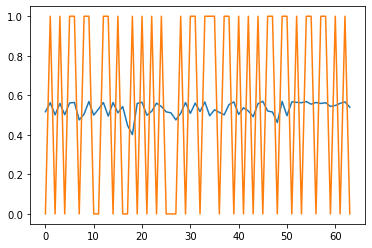

In [39]:
plt.figure()
plt.plot(valid_sets[1][0])
plt.plot(valid_sets[1][1])

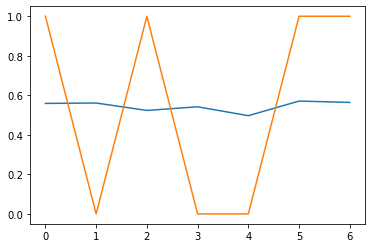

In [40]:
plt.figure()
plt.plot(pred.detach().cpu().numpy())
plt.plot(yb.detach().cpu().numpy())

In [108]:
h_ds

<xarray.Dataset>
Dimensions:         (hologram_number: 50000, particle: 500000, patch_number: 800000, patch_xsize: 128, patch_ysize: 128, xsize: 512, ysize: 512)
Dimensions without coordinates: hologram_number, particle, patch_number, patch_xsize, patch_ysize, xsize, ysize
Data variables: (12/16)
    hid             (particle) float32 1.0 1.0 1.0 1.0 ... 5e+04 5e+04 5e+04
    d               (particle) float32 36.48 45.38 25.82 ... 32.3 9.01 40.48
    x               (particle) float32 253.9 22.78 732.8 ... -616.6 -431.8
    y               (particle) float32 708.5 -600.7 552.2 ... 106.1 -190.7 662.5
    z               (particle) float32 5.645e+04 1.438e+05 ... 1.419e+05
    n0              (particle) float32 ...
    ...              ...
    x_pixels        (particle) float32 ...
    y_pixels        (particle) float32 ...
    pid             (particle) float32 ...
    x_patch_pixels  (particle) float32 ...
    y_patch_pixels  (particle) float32 ...
    patch           (patch_number, patch_xsize, patch_ysize) uint8 ...
Attributes: (12/33)
    DateCreated:           10-Feb-2021
    Nx:                    512.0
    Ny:                    512.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    monodisperse:          0.0
    should_cache:          1
    Nx_patch:              128.0
    Ny_patch:              128.0
    nPatches:              800000.0
    PatchesPerHologram:    16.0